In [55]:
import numpy as np
import pandas as pd
import os

In [56]:
# Load the CSV file and display the first 5 rows
df = pd.read_csv('Metro_median_sale_price_now_uc_sfrcondo_month.csv')
df.head()

,RegionID,SizeRank,RegionName,RegionType,StateName,2008-02-29,2008-03-31,2008-04-30,2008-05-31,2008-06-30,...,2024-10-31,2024-11-30,2024-12-31,2025-01-31,2025-02-28,2025-03-31,2025-04-30,2025-05-31,2025-06-30,2025-07-31
0,102001,0,United States,country,NaN,170500.0,175000.0,177000.0,180000.0,185000.0,...,352000.0,350000.0,350000.0,345000.0,350000.0,359000.0,364000.0,370000.0,376500.0,372919.0
1,394913,1,"New York, NY",msa,NY,400000.0,390000.0,390000.0,392500.0,400000.0,...,626000.0,625000.0,620000.0,640000.0,620000.0,620000.0,640000.0,650000.0,685000.0,690333.0
2,753899,2,"Los Angeles, CA",msa,CA,470000.0,455000.0,458000.0,440000.0,435000.0,...,940000.0,921000.0,935000.0,905000.0,950000.0,970000.0,950000.0,980000.0,1000000.0,966994.0
3,394463,3,"Chicago, IL",msa,IL,219000.0,220000.0,223000.0,229000.0,235000.0,...,306500.0,310000.0,300000.0,299900.0,300000.0,315000.0,329900.0,340000.0,355000.0,348582.0
4,394514,4,"Dallas, TX",msa,TX,138000.0,145500.0,144200.0,150000.0,155000.0,...,382250.0,385000.0,380000.0,374250.0,385000.0,392500.0,395000.0,400000.0,408250.0,401196.0


In [57]:
# Reshape the DataFrame to long format and calculate median price per state and year
df_melted = df.melt(
    id_vars=['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName'],
    var_name='date',
    value_name='median_sale_price'
)
df_melted['year'] = pd.to_datetime(df_melted['date'], errors='coerce').dt.year
median_price_state_year = df_melted.groupby(['StateName', 'year'])['median_sale_price'].median().reset_index()
median_price_state_year.head()

,StateName,year,median_sale_price
0,AK,2008,240330.0
1,AK,2009,232500.0
2,AK,2010,228446.0
3,AK,2011,219950.0
4,AK,2012,213700.0


In [58]:
median_price_state_year.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   StateName          900 non-null    object 
 1   year               900 non-null    int32  
 2   median_sale_price  899 non-null    float64
dtypes: float64(1), int32(1), object(1)
memory usage: 17.7+ KB


In [59]:
# Display the minimum and maximum year in the summary DataFrame
min_year = median_price_state_year['year'].min()
max_year = median_price_state_year['year'].max()
print(f"Min year: {min_year}, Max year: {max_year}")

Min year: 2008, Max year: 2025


In [60]:
# Load the mortgage CSV file into a new DataFrame
mortgage_df = pd.read_csv('MORTGAGE30US.csv')
mortgage_df.head()

,observation_date,MORTGAGE30US
0,1971-04-02,7.33
1,1971-04-09,7.31
2,1971-04-16,7.31
3,1971-04-23,7.31
4,1971-04-30,7.29


In [61]:
# Calculate the median mortgage rate by year
mortgage_df['year'] = pd.to_datetime(mortgage_df['observation_date']).dt.year
median_mortgage_by_year = mortgage_df.groupby('year')['MORTGAGE30US'].median().reset_index()
median_mortgage_by_year.head()

,year,MORTGAGE30US
0,1971,7.540
1,1972,7.400
2,1973,7.825
3,1974,9.125
4,1975,9.020


In [62]:
# Merge the two datasets on year, keeping only years present in mortgage_df
combined_df = pd.merge(median_price_state_year, median_mortgage_by_year, on='year', how='inner')
combined_df.head()

,StateName,year,median_sale_price,MORTGAGE30US
0,AK,2008,240330.0,6.040
1,AK,2009,232500.0,5.035
2,AK,2010,228446.0,4.735
3,AK,2011,219950.0,4.510
4,AK,2012,213700.0,3.660


In [63]:
# Rename the mortgage rate column for clarity
combined_df = combined_df.rename(columns={'MORTGAGE30US': 'mortgage_rate'})
combined_df.head()

,StateName,year,median_sale_price,mortgage_rate
0,AK,2008,240330.0,6.040
1,AK,2009,232500.0,5.035
2,AK,2010,228446.0,4.735
3,AK,2011,219950.0,4.510
4,AK,2012,213700.0,3.660


In [64]:
# Check for missing values in the combined DataFrame
combined_df.isnull().sum()


StateName            0
year                 0
median_sale_price    1
mortgage_rate        0
dtype: int64

In [65]:
# Drop any rows with null values from the combined DataFrame
combined_df = combined_df.dropna()
combined_df.isnull().sum()

StateName            0
year                 0
median_sale_price    0
mortgage_rate        0
dtype: int64

In [66]:
# Calculate estimated monthly home payment for a 30-year mortgage (360 payments)
def calc_monthly_payment(principal, annual_rate, n_payments=360):
    r = (annual_rate / 100) / 12
    if r == 0:
        return principal / n_payments
    return principal * (r * (1 + r) ** n_payments) / ((1 + r) ** n_payments - 1)

combined_df['monthly_payment'] = combined_df.apply(lambda row: calc_monthly_payment(row['median_sale_price'], row['mortgage_rate']), axis=1).round(2)
combined_df.head()

,StateName,year,median_sale_price,mortgage_rate,monthly_payment
0,AK,2008,240330.0,6.040,1447.09
1,AK,2009,232500.0,5.035,1253.09
2,AK,2010,228446.0,4.735,1189.62
3,AK,2011,219950.0,4.510,1115.76
4,AK,2012,213700.0,3.660,978.80


In [67]:
combined_df['StateName'].unique()

array(['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA', 'HI',
       'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI',
       'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV',
       'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT',
       'VA', 'VT', 'WA', 'WI', 'WV', 'WY'], dtype=object)

In [68]:
# Read all CSVs in state_income into a single DataFrame joined on observation_date, using state abbreviation from column name
import os
import pandas as pd
import re
state_income_dir = 'state_income'
files = [f for f in os.listdir(state_income_dir) if f.endswith('.csv')]
dfs = []
for f in files:
    df = pd.read_csv(os.path.join(state_income_dir, f))
    col = df.columns[1]
    match = re.search(r'MEHOINUS([A-Z]{2})A672N', col)
    state_abbr = match.group(1) if match else col
    df = df.rename(columns={col: state_abbr})
    dfs.append(df)
from functools import reduce
state_income_df = reduce(lambda left, right: pd.merge(left, right, on='observation_date', how='outer'), dfs)
state_income_df.head()

,observation_date,AL,AK,AZ,AR,CA,CO,CT,DE,FL,...,SD,TN,TX,UT,VT,VA,WA,WV,WI,WY
0,1984-01-01,45510,85070,56330,41210,66480,67830,78740,67880,52020,...,51030,44120,60530,60620,59360,69740,65770,44280,54530,62610
1,1985-01-01,46610,88440,60710,44370,68600,71660,79050,58430,54270,...,46130,45200,60370,64170,66110,72280,61020,40640,59110,56140
2,1986-01-01,47860,78440,63790,46850,72570,68020,81850,64100,57160,...,49770,45670,60440,65740,61530,74330,67240,41180,66110,58930
3,1987-01-01,47750,80410,64720,45550,72940,64060,79510,70760,59250,...,51180,51250,59820,64190,61490,72580,66100,41630,63800,66760
4,1988-01-01,46550,77240,61680,47070,70670,61170,84500,71180,59280,...,52020,48660,58250,61400,67640,76180,75430,45160,69010,61640


In [69]:
# Merge state_income_df with combined_df on year and state abbreviation
state_income_df['year'] = pd.to_datetime(state_income_df['observation_date']).dt.year
# Melt state_income_df to long format: columns = ['year', 'state', 'income']
income_long = state_income_df.melt(id_vars=['year'], var_name='StateName', value_name='income')
# Merge with combined_df on year and state abbreviation
final_df = pd.merge(combined_df, income_long, on=['year', 'StateName'], how='left')
final_df.head()

,StateName,year,median_sale_price,mortgage_rate,monthly_payment,income
0,AK,2008,240330.0,6.040,1447.09,87500
1,AK,2009,232500.0,5.035,1253.09,84570
2,AK,2010,228446.0,4.735,1189.62,78340
3,AK,2011,219950.0,4.510,1115.76,75440
4,AK,2012,213700.0,3.660,978.80,82020


In [70]:
# Add a column for percent of income spent on monthly payment (fix type error)
final_df['pct_income_monthly_payment'] = (final_df['monthly_payment']  / (final_df['income'] / 12)) * 100
final_df['pct_income_monthly_payment'] = pd.to_numeric(final_df['pct_income_monthly_payment'], errors='coerce').round(2)
final_df[['StateName', 'year', 'monthly_payment', 'income', 'pct_income_monthly_payment']].head()

,StateName,year,monthly_payment,income,pct_income_monthly_payment
0,AK,2008,1447.09,87500,19.85
1,AK,2009,1253.09,84570,17.78
2,AK,2010,1189.62,78340,18.22
3,AK,2011,1115.76,75440,17.75
4,AK,2012,978.80,82020,14.32


In [71]:
# Display the minimum and maximum percent of income spent on monthly payment
min_pct = final_df['pct_income_monthly_payment'].min()
max_pct = final_df['pct_income_monthly_payment'].max()
print(f"Min percent of income: {min_pct}")
print(f"Max percent of income: {max_pct}")

Min percent of income: 7.38
Max percent of income: 52.96


In [72]:
# Check for missing values in the final DataFrame
final_df.isnull().sum()

StateName                       0
year                            0
median_sale_price               0
mortgage_rate                   0
monthly_payment                 0
income                        100
pct_income_monthly_payment    100
dtype: int64

In [73]:
# Drop any rows with null values from the final DataFrame
final_df.dropna(inplace=True)
# Check again for missing values
final_df.isnull().sum() 


StateName                     0
year                          0
median_sale_price             0
mortgage_rate                 0
monthly_payment               0
income                        0
pct_income_monthly_payment    0
dtype: int64

In [74]:
# Manual spot check: Calculate monthly payment and burden percent for one row and compare to code output
sample_row = final_df.iloc[0]
principal = sample_row['median_sale_price']
rate = sample_row['mortgage_rate']
income = sample_row['income']

# Manual calculation
n_payments = 360
r = (rate / 100) / 12
if r == 0:
    manual_monthly_payment = principal / n_payments
else:
    manual_monthly_payment = principal * (r * (1 + r) ** n_payments) / ((1 + r) ** n_payments - 1)
manual_monthly_payment = round(manual_monthly_payment, 2)
manual_burden_pct = round((manual_monthly_payment / (income / 12)) * 100, 2)

print('Manual monthly payment:', manual_monthly_payment)
print('Code monthly payment:', sample_row['monthly_payment'])
print('Manual burden percent:', manual_burden_pct)
print('Code burden percent:', sample_row['pct_income_monthly_payment'])

Manual monthly payment: 1447.09
Code monthly payment: 1447.09
Manual burden percent: 19.85
Code burden percent: 19.85


In [75]:
final_df.count()

StateName                     799
year                          799
median_sale_price             799
mortgage_rate                 799
monthly_payment               799
income                        799
pct_income_monthly_payment    799
dtype: int64

In [76]:
# Export the final DataFrame to final.csv in the main directory
final_df.to_csv('final.csv', index=False)


In [77]:
# Calculate the percent difference between min and max year pct_income_monthly_payment for each state
result = final_df.groupby('StateName').apply(lambda g: g.loc[g['year'] == g['year'].max(), 'pct_income_monthly_payment'].values[0] - g.loc[g['year'] == g['year'].min(), 'pct_income_monthly_payment'].values[0]).reset_index()
result.columns = ['StateName', 'pct_diff_min_max_year']
result = result.sort_values('pct_diff_min_max_year', ascending=False)
result.head(len(result))

C:\Users\micha\AppData\Local\Temp\ipykernel_8484\3961997456.py:2: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result = final_df.groupby('StateName').apply(lambda g: g.loc[g['year'] == g['year'].max(), 'pct_income_monthly_payment'].values[0] - g.loc[g['year'] == g['year'].min(), 'pct_income_monthly_payment'].values[0]).reset_index()


,StateName,pct_diff_min_max_year
5,CO,24.81
12,ID,24.55
25,MT,24.23
4,CA,22.03
10,HI,21.18
31,NM,20.41
32,NV,19.31
43,UT,18.83
46,WA,18.37
8,FL,17.15


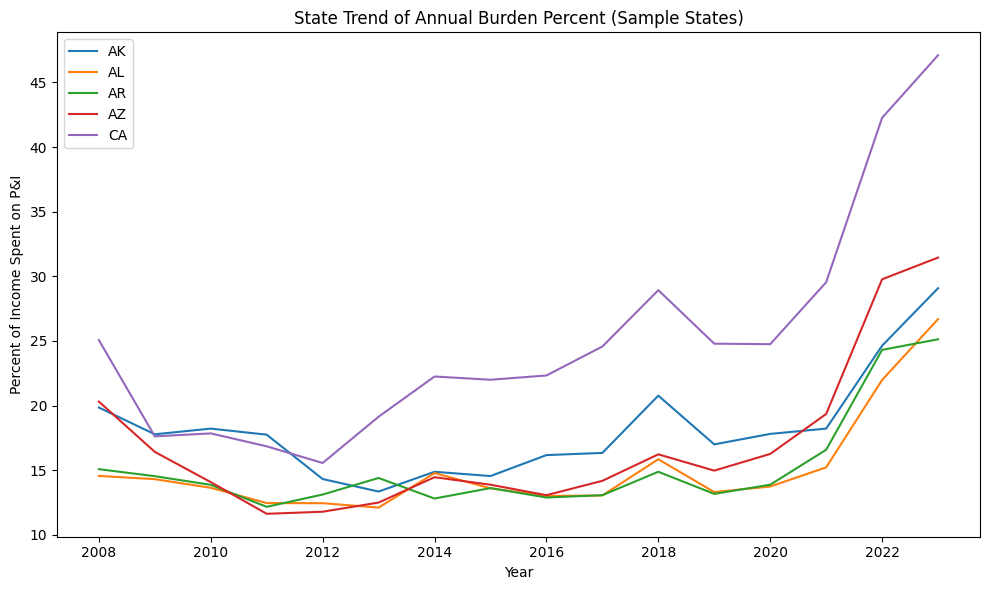

In [78]:
# State trend of annual burden percent (line plot for a sample of states)
import matplotlib.pyplot as plt
sample_states = final_df['StateName'].unique()[:5]  # Show first 5 states for clarity
plt.figure(figsize=(10,6))
for state in sample_states:
    state_data = final_df[final_df['StateName'] == state]
    plt.plot(state_data['year'], state_data['pct_income_monthly_payment'], label=state)
plt.xlabel('Year')
plt.ylabel('Percent of Income Spent on P&I')
plt.title('State Trend of Annual Burden Percent (Sample States)')
plt.legend()
plt.tight_layout()
plt.show()

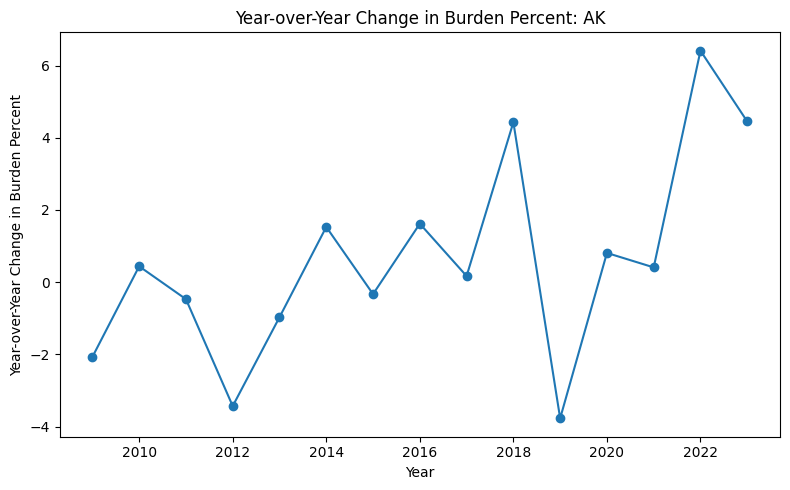

In [79]:
# Year-over-year change representation (line plot for a sample state)
sample_state = final_df['StateName'].unique()[0]
state_data = final_df[final_df['StateName'] == sample_state].sort_values('year')
yoy_change = state_data['pct_income_monthly_payment'].diff()
plt.figure(figsize=(8,5))
plt.plot(state_data['year'][1:], yoy_change[1:], marker='o')
plt.xlabel('Year')
plt.ylabel('Year-over-Year Change in Burden Percent')
plt.title(f'Year-over-Year Change in Burden Percent: {sample_state}')
plt.tight_layout()
plt.show()

C:\Users\micha\AppData\Local\Temp\ipykernel_8484\582851460.py:3: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  threshold_counts = final_df.groupby('year').apply(lambda g: (g['pct_income_monthly_payment'] >= threshold).sum())


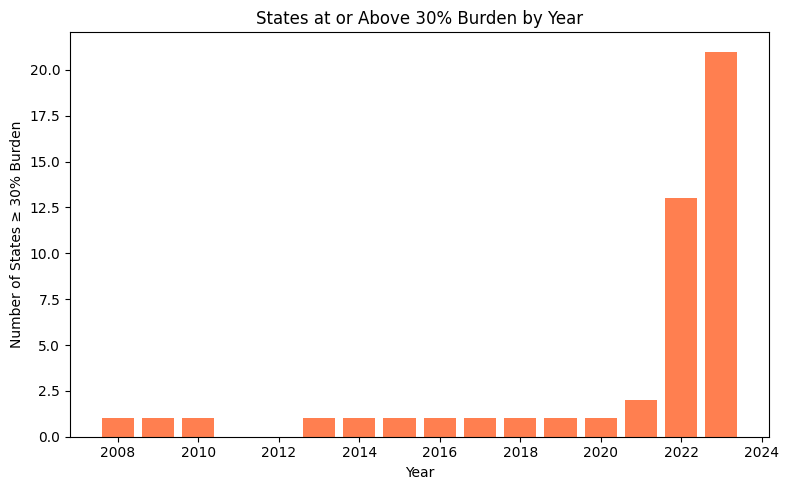

In [80]:
# Threshold classification view (bar chart: number of states at or above 30% burden per year)
threshold = 30
threshold_counts = final_df.groupby('year').apply(lambda g: (g['pct_income_monthly_payment'] >= threshold).sum())
plt.figure(figsize=(8,5))
plt.bar(threshold_counts.index, threshold_counts.values, color='coral')
plt.xlabel('Year')
plt.ylabel('Number of States ≥ 30% Burden')
plt.title('States at or Above 30% Burden by Year')
plt.tight_layout()
plt.show()

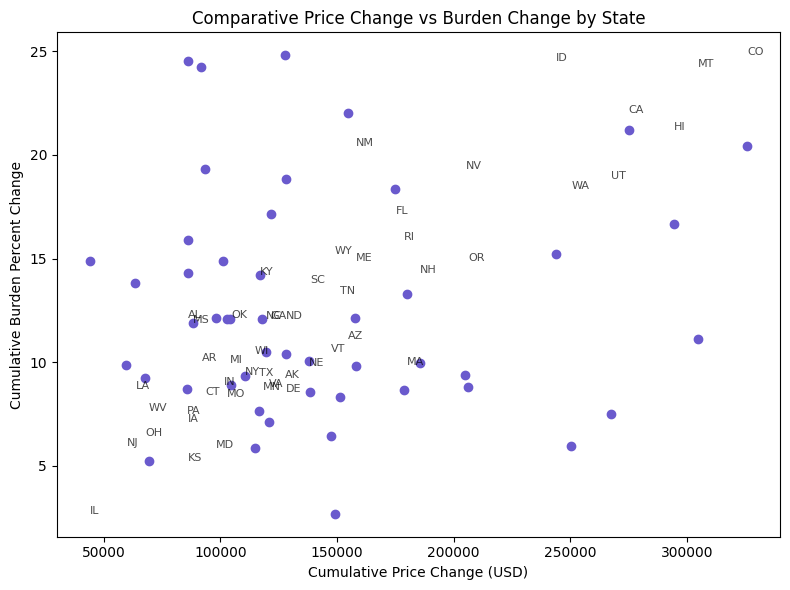

In [84]:
# Comparative price change vs burden change (scatter plot for all states)
first_year = final_df['year'].min()
last_year = final_df['year'].max()
price_change = final_df[final_df['year'] == last_year].set_index('StateName')['median_sale_price'] - final_df[final_df['year'] == first_year].set_index('StateName')['median_sale_price']
burden_change = result.set_index('StateName')['pct_diff_min_max_year']
plt.figure(figsize=(8,6))
plt.scatter(price_change, burden_change, color='slateblue')
plt.xlabel('Cumulative Price Change (USD)')
plt.ylabel('Cumulative Burden Percent Change')
plt.title('Comparative Price Change vs Burden Change by State')
for state in burden_change.index:
    plt.annotate(state, (price_change[state], burden_change[state]), fontsize=8, alpha=0.7)
plt.tight_layout()
plt.show()

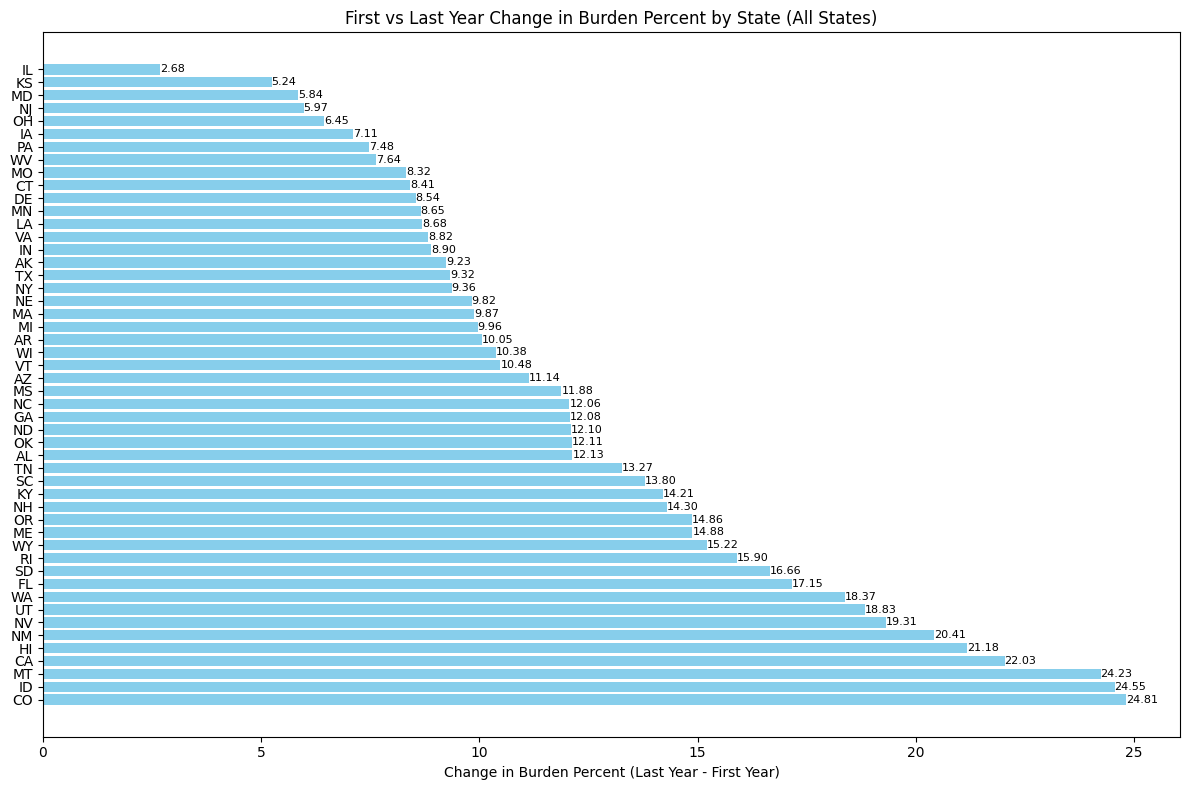

In [85]:
# First vs last year change view (bar chart for all states, using results DataFrame)
import matplotlib.pyplot as plt
results_sorted = result.set_index('StateName').sort_values('pct_diff_min_max_year', ascending=False)
plt.figure(figsize=(12,8))
bars = plt.barh(results_sorted.index, results_sorted['pct_diff_min_max_year'], color='skyblue')
plt.xlabel('Change in Burden Percent (Last Year - First Year)')
plt.title('First vs Last Year Change in Burden Percent by State (All States)')
plt.tight_layout()
for bar, value in zip(bars, results_sorted['pct_diff_min_max_year']):
    plt.text(value, bar.get_y() + bar.get_height()/2, f'{value:.2f}', va='center', ha='left', fontsize=8)
plt.show()